Тетрадка - вариант решения тестового задания. ТГ для связи: https://t.me/Serge_koval

## Основная часть

Использование встроенного в Open_CV функционала не дало достаточного качества, пришлось использовать внешние библиотеки. Кстати, и распознавание текста из цветного изображения проходит, на мой взгляд, получше, чем ч/б.

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 28.2 MB/s 
     |████████████████████████████████| 145 kB 43.0 MB/s 
     |████████████████████████████████| 604 kB 50.9 MB/s 
     |████████████████████████████████| 47.6 MB 85 kB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 9.9 MB/s 


В качестве "якорной точки" ориентируемся на наличие фото. Другие элементы в качестве шаблона не очень подходят. Распознать "Российская Федерация" можно только после детекции, - а присутствует не всегда. Проблеммы и с номером по правому борту.

In [ ]:
# cv
import cv2
import PIL
import numpy as np
from mtcnn import MTCNN
import easyocr

# general
import os
import string
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
CURRENT = "current.png"
letters = "".join([chr(x) for x in range(ord('а'), ord('я') + 1)]) + 'ё'
CHARS = letters + letters.upper() + string.digits + '.'
reader = easyocr.Reader(["ru"])
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
detector = MTCNN()

 
class NotFacesFoundError(Exception):
    pass

class NameNotFoundError(Exception):
    pass


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [ ]:
def save_rectangle(im, mask, filename=CURRENT):
    saved_img = cv2.bitwise_and(im, im, mask=mask)
    cv2.imwrite(filename, saved_img)
    return saved_img


def check_coord(c, tr_h, w_c):
    h, w, x_c = c[3][1] - c[0][1], c[1][0] - c[0][0], (c[0][0] + c[1][0]) / 2
    return (h > 0.8 * tr_h) and (w_c - 2 * w < x_c < w_c + 2 * w)


def get_text_result(textes, tr_conf=0.5):
    res = []
    tr = []  # собираем высоту боксов (ориентируемся на 3 самых высоких), центры по горизонтали

    for coord, text, confidence in textes:
        words = [word.upper() for word in text.split() if word.isalpha()]  # ["WORD_A", "WORD_B"]
        if words and confidence > tr_conf:
            tr.append((coord[3][1] - coord[0][1], (coord[0][0] + coord[1][0]) / 2))
            res.append((coord, words[0]))  # Для этого варианта только 1 слово
    
    if len(res) < 3:
        raise  NameNotFoundError
    
    tr.sort(reverse=True)
    tr_h = tr[2][0] if len(tr) > 2 else sum([h for h, x in tr[:3]]) / 3
    w = [x_c for h, x_c in tr]
    w.sort()
    w_c = sum(w[:3]) / 3

    res = [pair for pair in res if check_coord(pair[0], tr_h, w_c)]    # отбросили те, что ниже порога
    res = sorted(sorted(res, key=lambda pair: pair[0][0][0]), key=lambda pair: pair[0][0][1])   # "Y" по возрастанию ("Х" по возрастанию)

    keys = ("Фамилия", "Имя", "Отчество")
    answer = {key: val[-1] for key, val in zip(keys, res)}
    if len(answer) == 3:
        return answer
    raise NameNotFoundError


def get_faces_coord_cnn(im_colored, x_min, y_min, x_max, y_max):
    " MTCNN coord , - возвращаем 1 box"
    res = detector.detect_faces(im_colored)
    boxes = [item.get('box') for item in res]
    if boxes:
        return boxes[0]
 
    raise NotFacesFoundError(boxes, x_min, y_min, x_max, y_max)


def get_mask(shape, x1, y1, x2, y2):
    mask = np.zeros(shape[:2], np.uint8)
    cv2.rectangle(mask, pt1=(x1, y1), pt2=(x2, y2), color=255, thickness=-1)
    return mask


def erose_border(img):
    corners = np.uint0(cv2.goodFeaturesToTrack(img, 20, 0.05, 200))
    x_min, y_min = img.shape
    x_max, y_max = 0, 0
    for corner in corners:
        x, y = corner.ravel()
        x_min, y_min = min(x_min, x), min(y_min, y)
        x_max, y_max = max(x_max, x), max(y_max, y)

    mask = get_mask(img.shape, x_min, y_min, x_max, y_max)
    img = cv2.bitwise_and(img, img, mask=mask)

    return img, (x_min, y_min, x_max, y_max)


def save_crop_text(im, x, y, w, h, filename, denoiser=None):
    # рассчет координат для окна с ФИО"
    x1, y1 = x + int(1.9 * w), y - int(1.29 * h)
    x2, y2 = x + int(7.6 * w), y + h - int(0.33 * h)
    if denoiser:
        pass
        # маскирование фото
        mask1 = get_mask(im.shape, int(x - 0.2 * w), int(y - 0.2 * h), int(x + 1.2 * w), int(y + 1.2 * h)) 
        im = cv2.bitwise_or(im, im, mask=mask1)
        im = denoiser(im)

    mask2 = get_mask(im.shape[:2], x1, y1, x2, y2)  
    return save_rectangle(im, mask2, filename)


def best_ocr(temp_file):
    text = reader.readtext(temp_file, 
                           decoder='beamsearch', 
                           contrast_ths=0.25, 
                           allowlist=CHARS,           # возможно ведет к переобучению
                           min_size=15)
    return text


def convert_image2text(image_file, temp_file=CURRENT, ocr_func=best_ocr):
    img_c = cv2.imread(image_file)
    img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)   # на цветном даже лучше не только фото искать, но и OCR отрабатывает хорошо.
    img = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)

    #  Определим точки внешнего контура,- не дать внешнему контуру внести смещение в denoising
    img, (x_min, y_min, x_max, y_max) = erose_border(img)

    # фотография будет служить привязкой для окна, в котором ищем ФИО
    x, y, w, h = get_faces_coord_cnn(img_c, x_min, y_min, x_max, y_max)   # NotFacesFoundError!!
    cv2.rectangle(img, (x, y), (x + w, y + h), 0, 3)

    # выделяем и сохраняем целевой сегмент
    cropp = save_crop_text(img_c, x, y, w, h, filename=temp_file, denoiser=None)

    text = ocr_func(temp_file)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 18))
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(cropp, cmap='gray', vmin=0, vmax=255)
    plt.show()

    return text


## Эта часть относится к боту,- раз просили API.
И поскольку цели чисто тестовые - самая простая из библиотек.

In [ ]:
!pip install pytelegrambotapi

In [ ]:
from io import BytesIO
from telebot import types
from telebot import TeleBot
import requests
from telebot import apihelper
import logging
from tele_token import  TOKEN     # файл с токеном



def store_photo_id(bot, message, image_files):
    # нужно получить  картинки, поэтому будем сохранять id  картинки в словарь
    chat_id = message.chat.id
    # получаем информацию о картинке , сохраняем photo_Id   за пользователем
    image_id = message.photo[-1].file_id
    print('Obtained file_obj = ', image_id)
    image_files[chat_id] = image_id
    

def save_photo(bot, image_id, file_name):
    image_file_obj = bot.get_file(image_id)
    image_file = bot.download_file(image_file_obj.file_path)

    # bytes переводим в Image и далее в тензор
    image_file = BytesIO(image_file)
    image_file.seek(0)
    image = PIL.Image.open(image_file)
    print("image_shape", image.size)
    image.save(file_name)


def main_bot():
    image_files = {}  
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO)

    bot = TeleBot(TOKEN)
    command = "прочитать ФИО по скану"

    markup_menu = types.ReplyKeyboardMarkup(resize_keyboard=True, row_width=3)  
    markup_menu.add(types.KeyboardButton(command))


    @bot.message_handler(commands=['start', 'help'])
    def send_welcome(message: types.Message):
        text = ""
        if message.text == "/start":
            text = "У бота только одна опция: прочитать ФИО по скану паспорта"
        elif message.text == "/help":
            text = "простой последовательный бот для парсинга ФИО"
        bot.send_message(message.chat.id, text, reply_markup=markup_menu) 
            

    @bot.message_handler(content_types=['photo'])
    def photo(message):
        store_photo_id(bot, message, image_files)


    @bot.message_handler(func=lambda message: True)
    def send_welcome(message: types.Message):
        text_template = "отправьте скан паспорта, страница с текстом должна располагаться горизонтально"
        chat_id = message.chat.id
        file_name = str(chat_id) + ".png"

        if message.text == command:
            if chat_id in image_files:
                bot.send_message(chat_id, 
                                     "Файл получен, обработка займет несколько минут",
                                     reply_markup=markup_menu
                                    )
                try:
                    save_photo(bot, image_files[chat_id], file_name)
                    texts = convert_image2text(file_name) 
                    answer = get_text_result(texts)  
                    print("OK! answer=", answer) 
                    text = "\n".join([f"{key}: {val}" for key, val in answer.items()])
                    bot.send_message(chat_id, 
                                     text,
                                     reply_markup=markup_menu
                                    )
                except NotFacesFoundError:
                    bot.send_message(chat_id, 
                                     "Возможно это скан, и даже скан паспорта, но бот не смог его распознать\n" + text_template,
                                     reply_markup=markup_menu
                                    )
                except NameNotFoundError as e:
                    print("NameNotFoundError <> file_name, texts:", file_name, texts)
            else:
                bot.send_message(chat_id, 
                                 "Сначала " + text_template,
                                 reply_markup=markup_menu
                                )
        else:
            bot.send_message(chat_id, 
                                f'{message.text} -что это было???',
                                reply_markup=markup_menu
                                )

    bot.polling(none_stop=True, timeout=60)

Запускать бота здесь (раскомментировать):

In [ ]:
# main_bot()

## Демо- часть.

Пример обработки тестовых сканов. Не все читаются хорошо. В примере понизил порог уверенности до 0.3, но правильнее говорить "Не знаю" при большем пороге . Также есть сомнение в полезности allow_list - возможно достовернее было бы избежать подгонки и отбрасывать не литеральные ответы.

In [ ]:
filenames = []
for filename in sorted(os.listdir(os.getcwd())):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        filenames.append(filename)
", ".join(filenames)

'0.jpeg, 1.jpeg, 2.jpeg, 3.jpeg, 4.png, 5.jpeg, 6.jpeg, 7.jpeg, 8.jpeg, 9.jpeg, current.png'

1/1 [==============================] - 0s 36ms/step


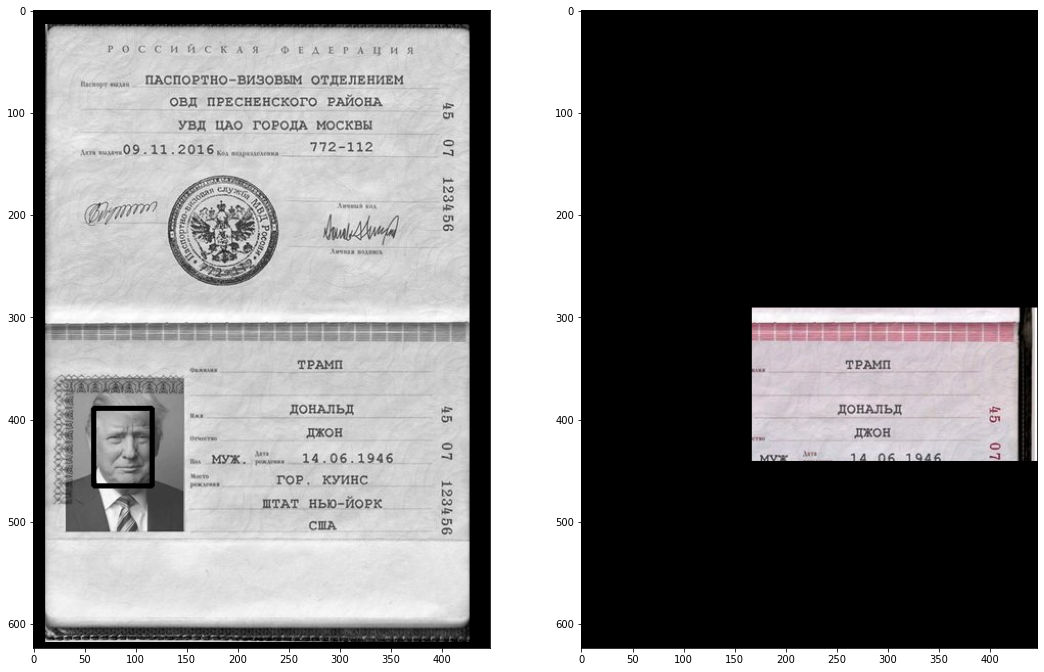

OK! answer= {'Фамилия': 'ТРАМП', 'Имя': 'ДОНАЛЬД', 'Отчество': 'ДЖОН'}
----------------------------------------
1/1 [==============================] - 0s 32ms/step


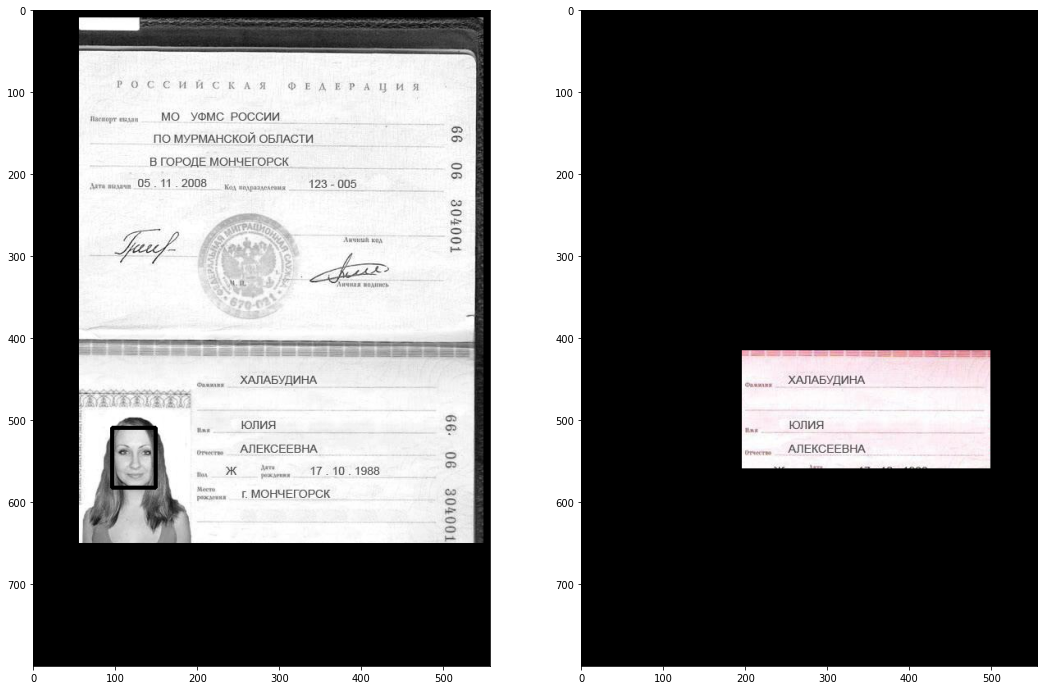

OK! answer= {'Фамилия': 'ХАЛАБУДИНА', 'Имя': 'ЮЛИЯ', 'Отчество': 'АЛЕКСЕЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 35ms/step


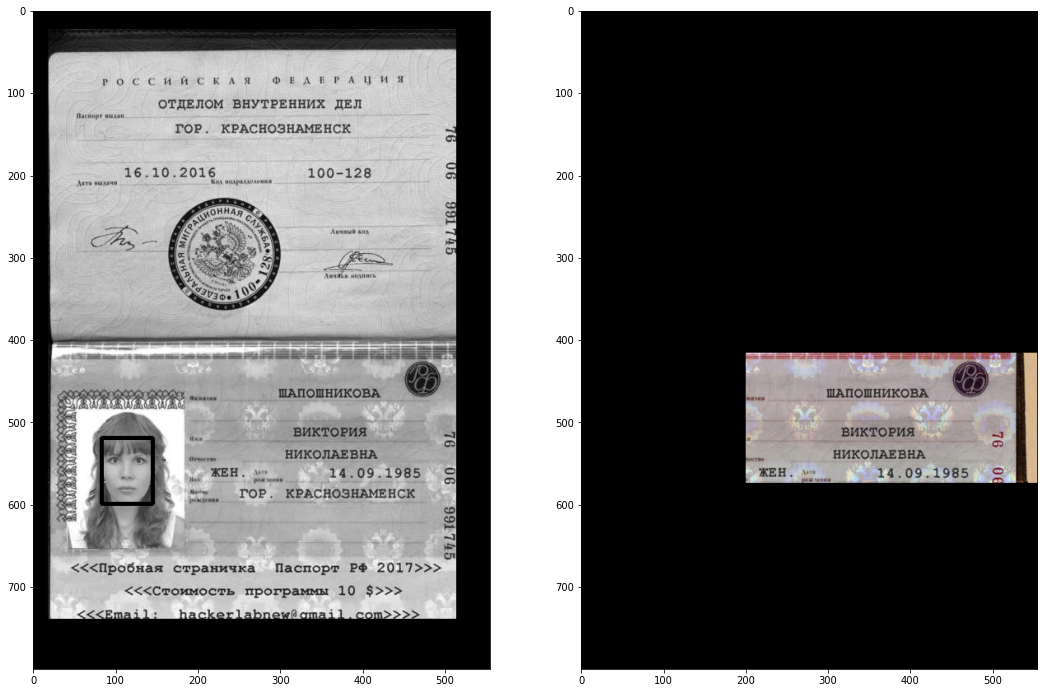

OK! answer= {'Фамилия': 'ШАПОШНИКОВА', 'Имя': 'ВИКТОРИЯ', 'Отчество': 'НИКОЛАЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 29ms/step


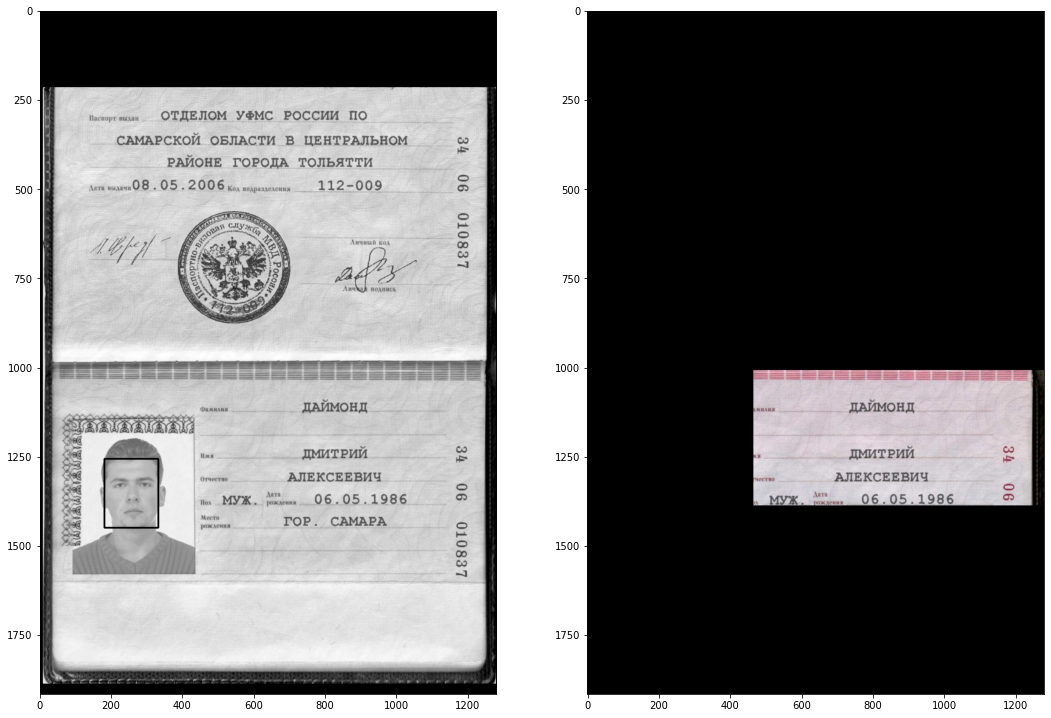

OK! answer= {'Фамилия': 'ДАЙМОНД', 'Имя': 'ДМИТРИЙ', 'Отчество': 'АЛЕКСЕЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


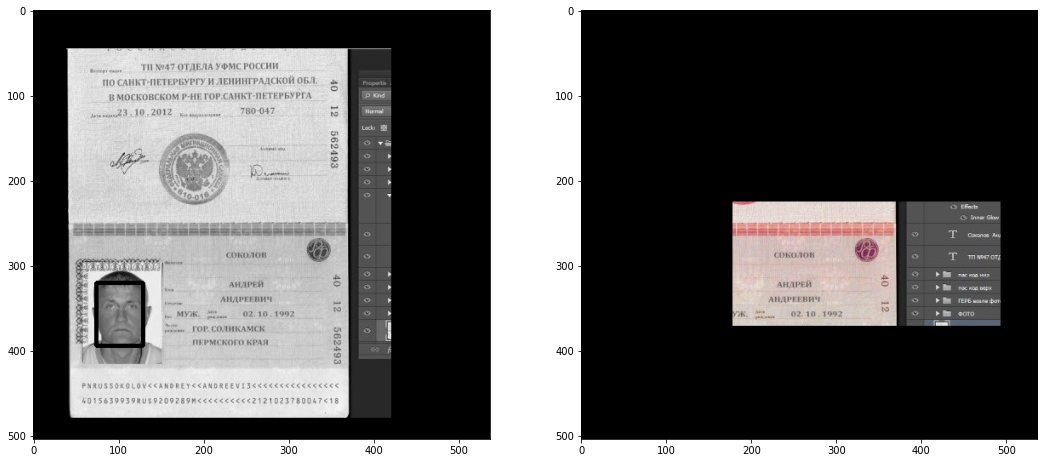

OK! answer= {'Фамилия': 'СОКОЛОВ', 'Имя': 'АНДРЕИ', 'Отчество': 'АНДРЕЕНИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


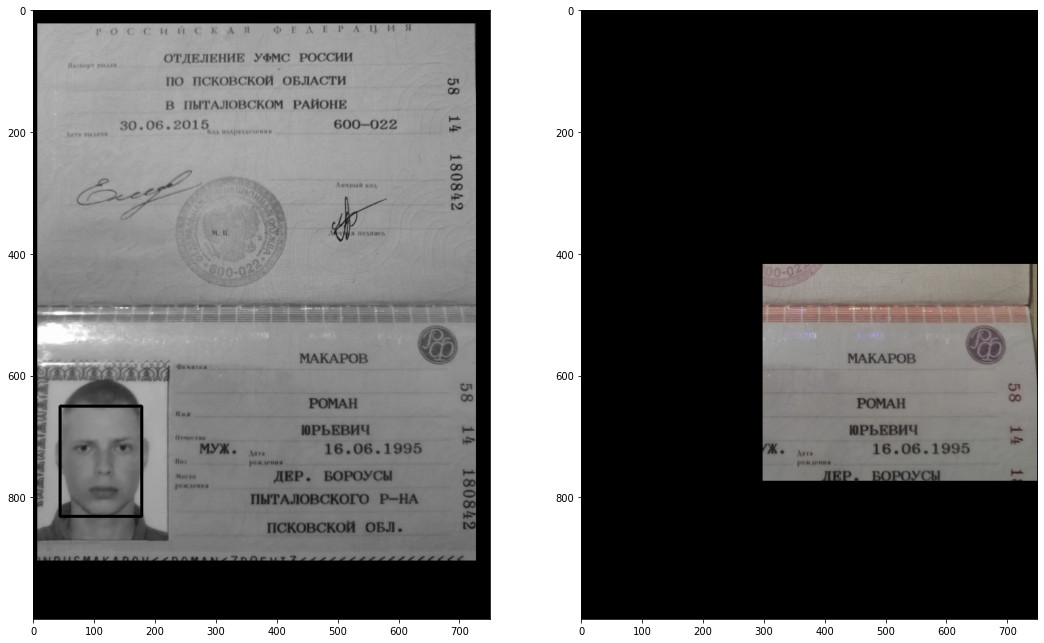

OK! answer= {'Фамилия': 'МАКАРОВ', 'Имя': 'РОМАН', 'Отчество': 'ЮРЬЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 40ms/step


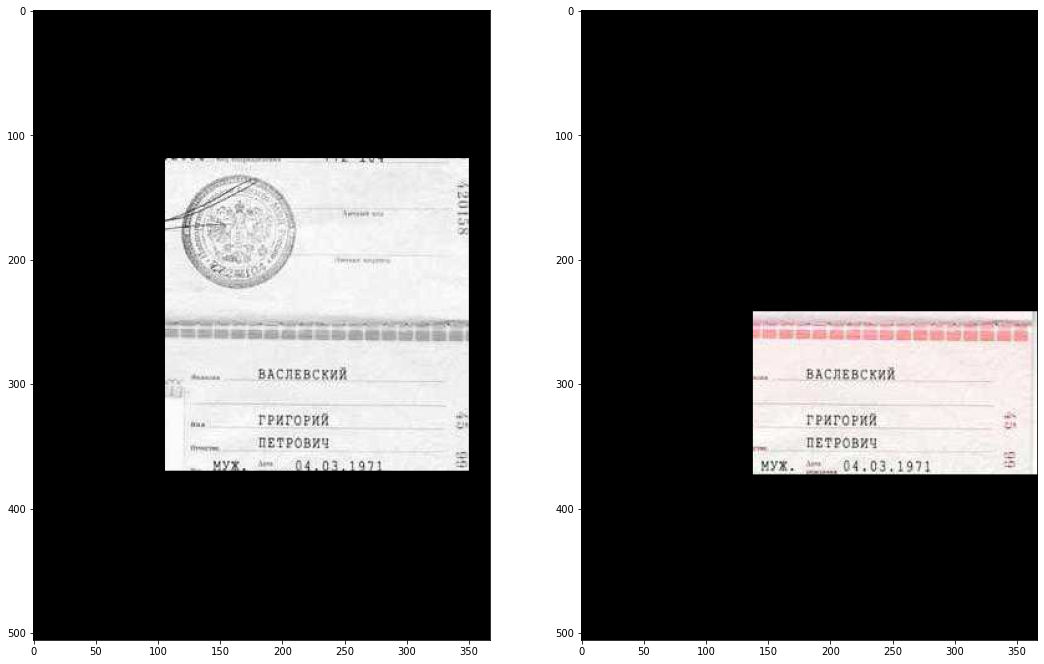

OK! answer= {'Фамилия': 'ВАСЛЕВСКИЯ', 'Имя': 'ГРКГОРЖЯ', 'Отчество': 'ПЕТРОВИЦ'}
----------------------------------------
1/1 [==============================] - 0s 49ms/step


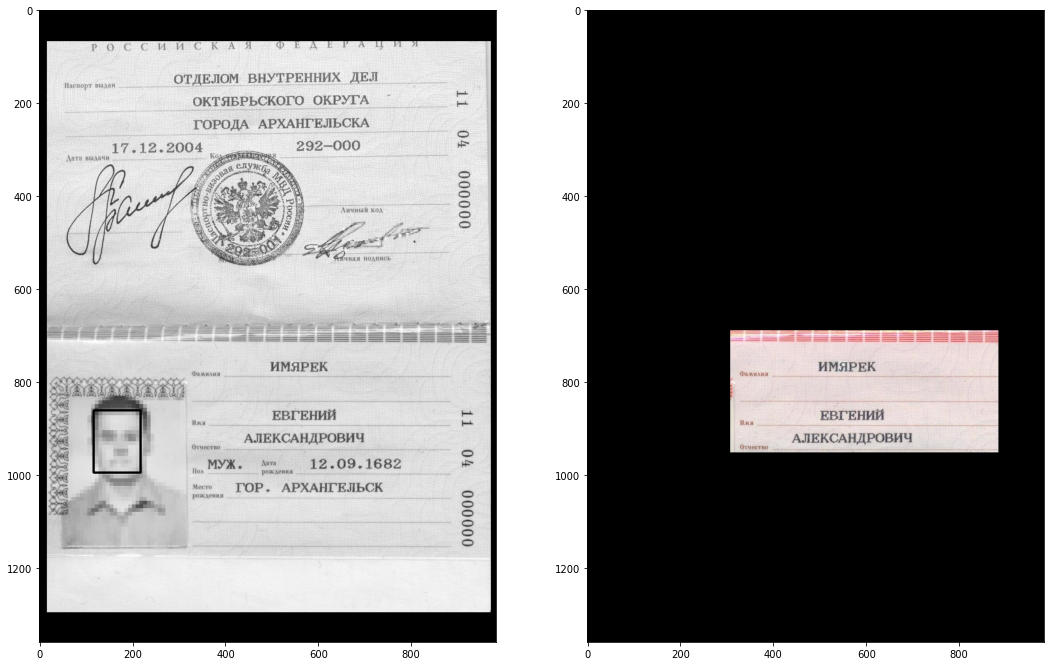

OK! answer= {'Фамилия': 'ИМЯРЕК', 'Имя': 'ЕВГЕНИЙ', 'Отчество': 'АЛЕКСАНДРОВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 37ms/step


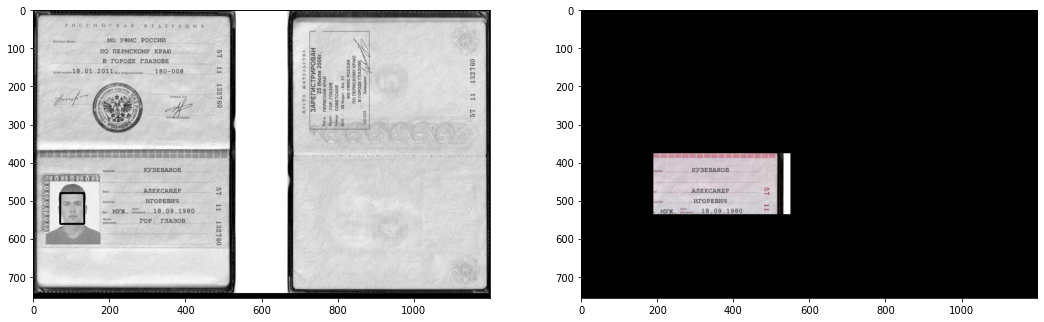

OK! answer= {'Фамилия': 'КУЗЕВАНОВ', 'Имя': 'АЛЕКСАНДР', 'Отчество': 'ИГОРЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 58ms/step


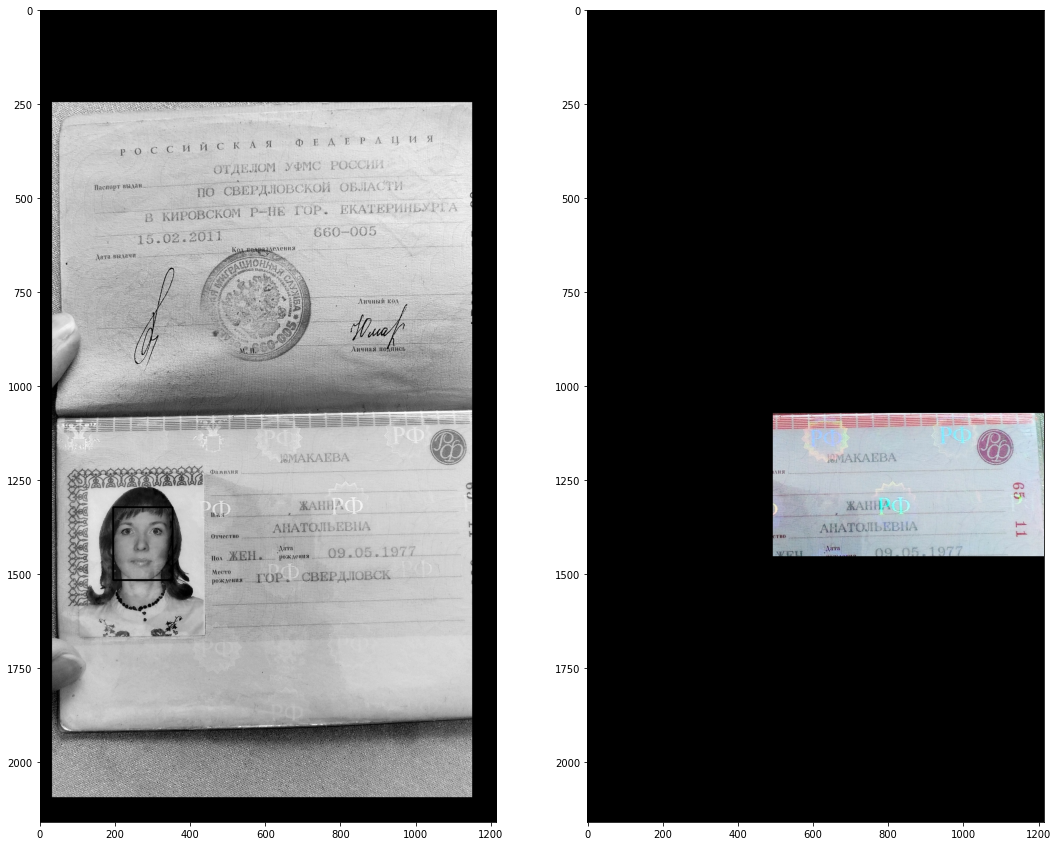

NameNotFoundError <> file_name, texts: 9.jpeg [([[589, 1109], [682, 1109], [682, 1170], [589, 1170]], '5а', 0.018480074415621446), ([[934, 1104], [1028, 1104], [1028, 1160], [934, 1160]], 'РФ', 0.9998688415268309), ([[629, 1173], [827, 1173], [827, 1209], [629, 1209]], 'ЗМАКАЕВА', 0.248599807484206), ([[497, 1223], [529, 1223], [529, 1237], [497, 1237]], 'лия', 0.9264630048042338), ([[1127, 1251], [1167, 1251], [1167, 1307], [1127, 1307]], 'с', 0.8324159104233786), ([[685, 1301], [777, 1301], [777, 1337], [685, 1337]], 'ЖАНН', 0.32086890935897827), ([[768, 1290], [866, 1290], [866, 1346], [768, 1346]], 'РРФ', 0.9841076592361885), ([[616, 1355], [883, 1355], [883, 1397], [616, 1397]], 'АНАТОЛЬЕВНА', 0.9804577381277528), ([[1135, 1353], [1173, 1353], [1173, 1407], [1135, 1407]], '6', 0.2684134907234501), ([[501, 1395], [531, 1395], [531, 1407], [501, 1407]], 'ТНО', 0.39160811318710864), ([[633, 1423], [675, 1423], [675, 1443], [633, 1443]], 'Дата', 0.9490910768508911), ([[830, 1423], [88

In [ ]:
for file_name in filenames:   
    try:
        texts = convert_image2text(file_name) 
        answer = get_text_result(texts, tr_conf=0.3)  
        print("OK! answer=", answer) 
    except NotFacesFoundError:
        print("Not found face --> aborted")
    except NameNotFoundError as e:
        print("NameNotFoundError <> file_name, texts:", file_name, texts)
    print("--" * 20)

Паспорта Васлевского, Юмакаевой и Соколова читаются плохо, с ошибками. Но порог уверенности модели в этом демонстрационном примере поставлен низким(0.3) - поэтому ошибка выскакивает только на Юмакаевой, остальные 2  прочитаны с опечатками.

## Denoising autoencoder вместо встроенных фильтров Open_CV (предобученная модель взята отсюда : https://github.com/anubhabdaserrr/document-denoising-autoencoder)


In [ ]:
import numpy as np
import cv2

#For building models
import tensorflow as tf
from tensorflow.keras import layers, Sequential

#Visualization
import matplotlib.pyplot as plt

#Misc
import os
import glob
import pickle

%matplotlib inline

Дальше всякие  первичные эксперименты - не особо нужно, закомментировал. Оставил для себя.

In [ ]:
model = tf.keras.models.load_model('/content/model')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 210, 270, 32)      320       
                                                                 
 conv2d_10 (Conv2D)          (None, 105, 135, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 105, 135, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 210, 270, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 420, 540, 32)     18464     
 ranspose)                                                       
                                                      

In [ ]:
IMG_SIZE_CV2 = (540,420)

def process_image(path):
    img = cv2.imread(path)
    original_size = img.shape
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, IMG_SIZE_CV2)

    if len(img.shape) == 3 : 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert colour image to grayscale
        img = img / 255.0 
    img = np.reshape(img, (IMG_SIZE_CV2[1], IMG_SIZE_CV2[0], 1))
    
    return img, original_size

In [ ]:
filenames = []
for filename in sorted(os.listdir(os.getcwd())):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        filenames.append(filename)
", ".join(filenames)

'0.jpeg, 1.jpeg, 2.jpeg, 3.jpeg, 4.png, 5.jpeg, 6.jpeg, 7.jpeg, 8.jpeg, 9.jpeg'

In [ ]:
def autoencoder_denoiser(img):
    original_size = img.shape
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, IMG_SIZE_CV2)

    img = img / 255.0 
    img = np.expand_dims(img, -1)
    new_img = model.predict(np.asarray([img]), batch_size=1)
    new_img = cv2.resize(np.squeeze(new_img), original_size[::-1])
    return new_img


def billateral_denoiser(img):
    ret, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.bilateralFilter(img, 3, int(0.1 * ret), max(1.3 * ret, 100))


def save_crop_box_text(im, x, y, w, h, filename, denoiser=None):
    # рассчет координат для окна с ФИО"
    x1, y1 = x + int(1.9 * w), y - int(1.29 * h)
    x2, y2 = x + int(7.6 * w), y + h - int(0.33 * h)
    if denoiser:
        # маскирование фото - убрать смещение
        mask1 = 255 - get_mask(im.shape[:2], int(x - 0.2 * w), int(y - 0.2 * h), int(x + 1.2 * w), int(y + 1.2 * h)) 
        im = cv2.bitwise_and(im, im, mask=mask1)
        im = denoiser(im)

    mask2 = get_mask(im.shape[:2], x1, y1, x2, y2)   
    return save_rectangle(im, mask2, filename)


def simple_recognition(filename):
    img = cv2.imread(filename)
    if len(img.shape) == 3 : 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5), )
    dilated = cv2.dilate(img, kernel, iterations=6)
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    res = []
    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)

        mask = get_mask(img.shape, x, y, x + w, y + h)
        save_rectangle(img, mask, filename)
    
        try:
            text = reader.readtext(filename, detail=0, paragraph=False, text_threshold=0.7)
            # print("text:", text, end="||")
            text = [words for words in text if all(word.isalpha() for word in words.split())]
            # print(text)
            if text:
                res.append((x, y, w, h, " ".join(text)))
                print(text)
            else: 
                print("not_text", text)
        except Exception as e:
            print(f"not parsed and len(text)= {len(text)}, ...", e, text)



def convert_image2gray_text(image_file, temp_file=CURRENT, ocr_func=best_ocr, denoiser=autoencoder_denoiser):
    img_c = cv2.imread(image_file)
    img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)   # на цветном даже лучше не только фото искать, но и OCR отрабатывает хорошо.
    img = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)

    #  Определим точки внешнего контура,- не дать внешнему контуру внести смещение в denoising
    img, (x_min, y_min, x_max, y_max) = erose_border(img)

    # фотография будет служить привязкой для окна, в котором ищем ФИО
    x, y, w, h = get_faces_coord_cnn(img_c, x_min, y_min, x_max, y_max)   # NotFacesFoundError!!
    cv2.rectangle(img, (x, y), (x + w, y + h), 0, 3)

    # выделяем и сохраняем целевой сегмент
    im_window = img[int(y_min): int(y_max + 1), int(x_min): int(x_max + 1)]
    cropp = save_crop_box_text(img, x, y, w, h, filename=temp_file, denoiser=denoiser)

    text = ocr_func(temp_file)

    fig, ax = plt.subplots(1, 2, figsize=(18, 18))
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(cropp, cmap='gray', vmin=0, vmax=255)
    plt.show()

    return text

1/1 [==============================] - 0s 35ms/step


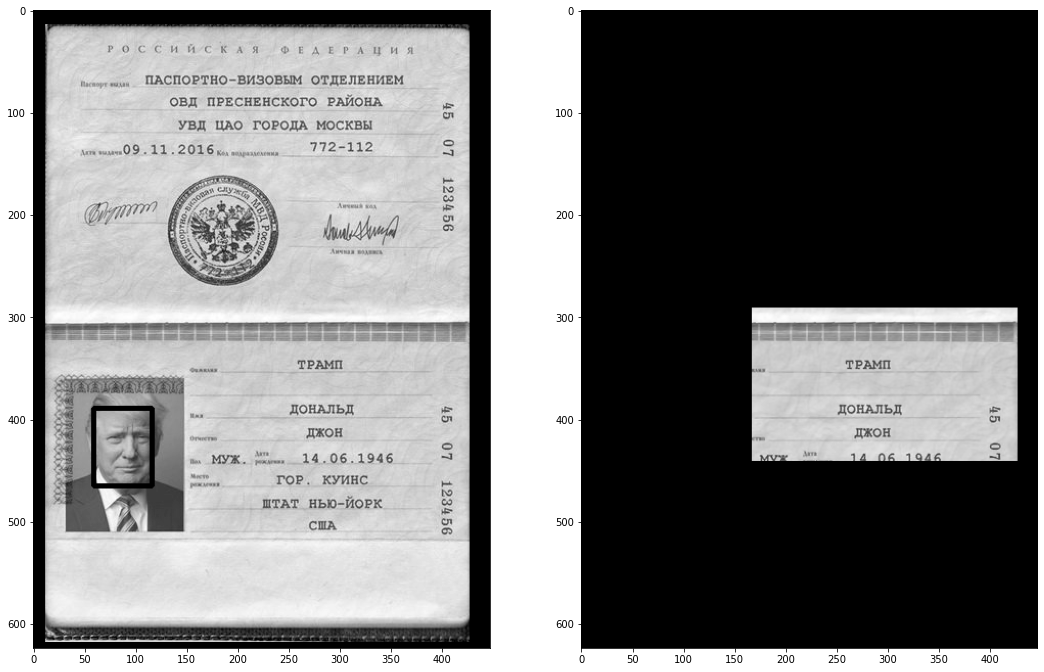

OK! answer= {'Фамилия': 'ТРАМП', 'Имя': 'ДОНАЛЬД', 'Отчество': 'ДЖОН'}
----------------------------------------
1/1 [==============================] - 0s 26ms/step


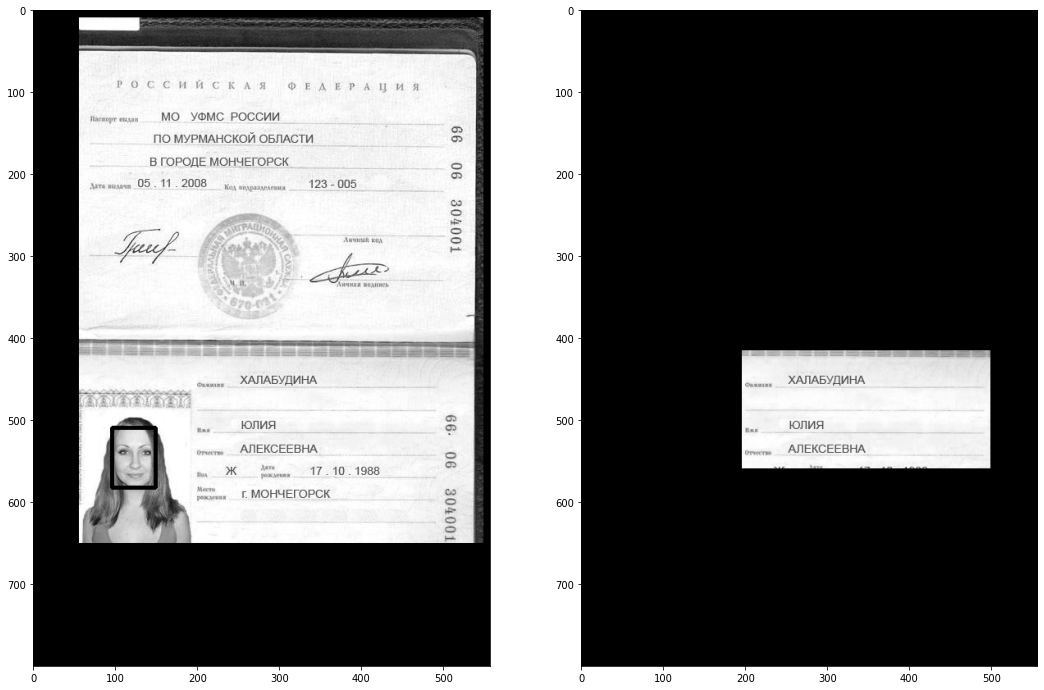

OK! answer= {'Фамилия': 'ХАЛАБУДИНА', 'Имя': 'ЮЛИЯ', 'Отчество': 'АЛЕКСЕЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 43ms/step


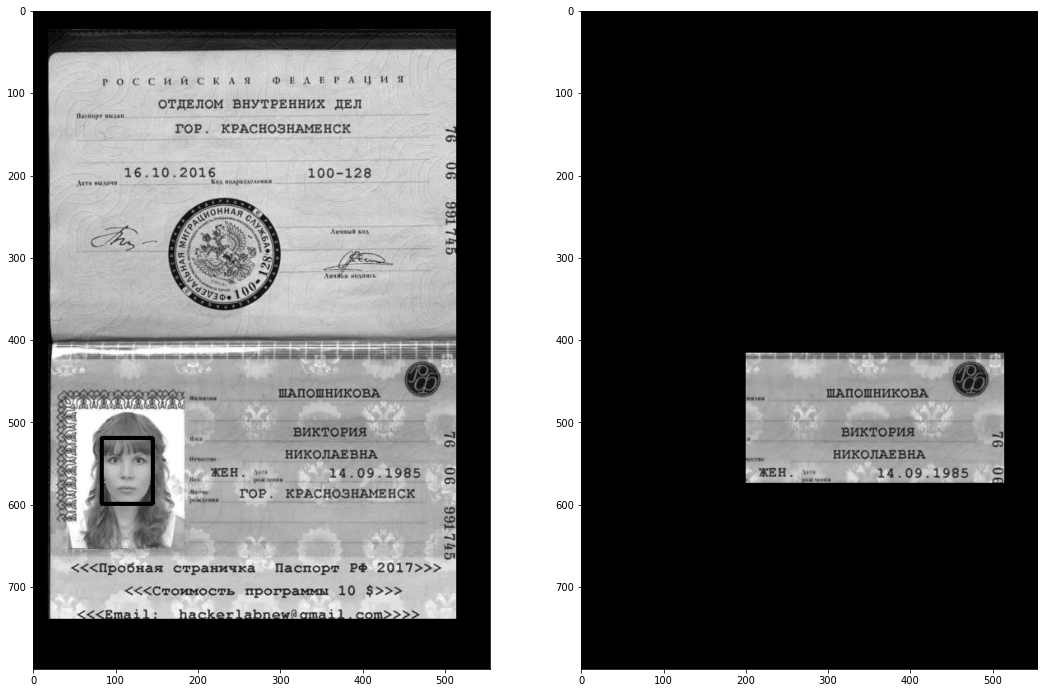

OK! answer= {'Фамилия': 'ШАПОШНИКОВА', 'Имя': 'ВИКТОРИЯ', 'Отчество': 'НИКОЛАЕВНА'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


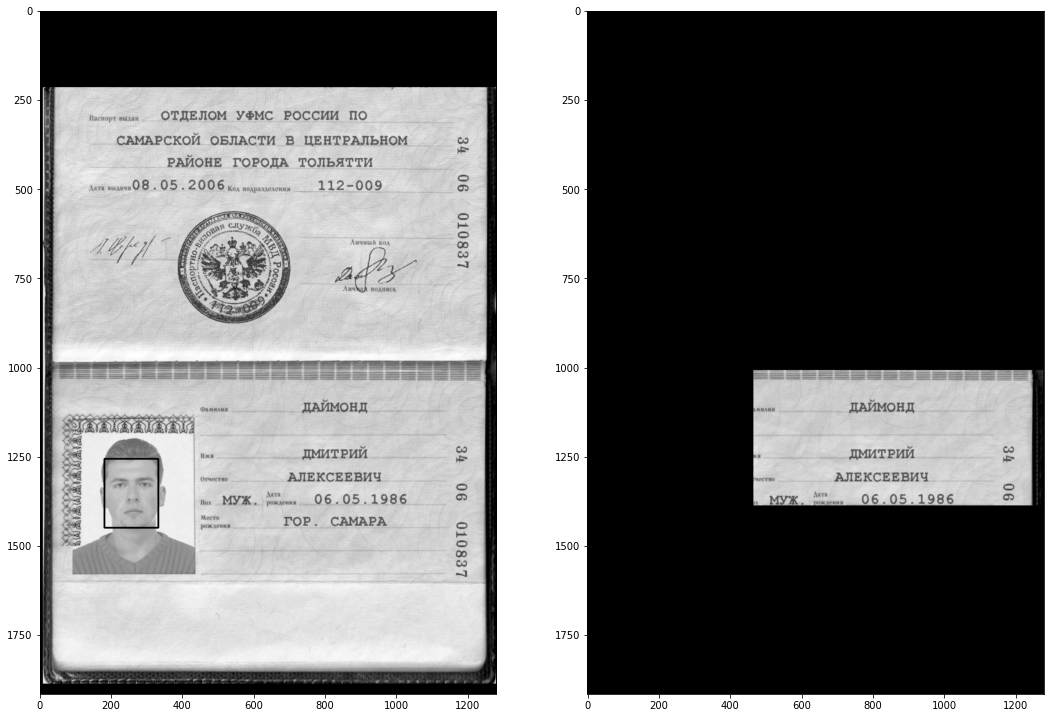

OK! answer= {'Фамилия': 'ДАЙМОНД', 'Имя': 'ДМИТРИЙ', 'Отчество': 'АЛЕКСЕЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 28ms/step


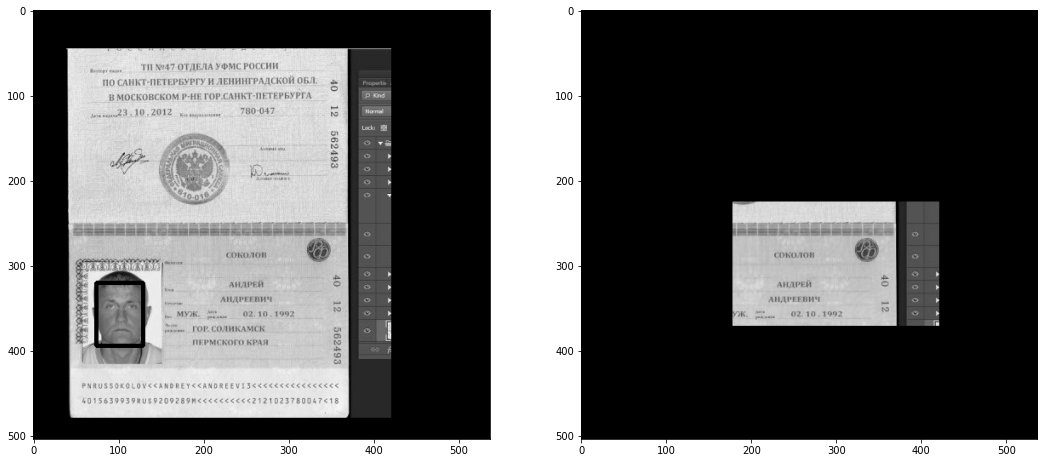

OK! answer= {'Фамилия': 'СОКШЛАН', 'Имя': 'АНДРЕИ', 'Отчество': 'АНДРЕЕНИЧ'}
----------------------------------------
1/1 [==============================] - 0s 36ms/step


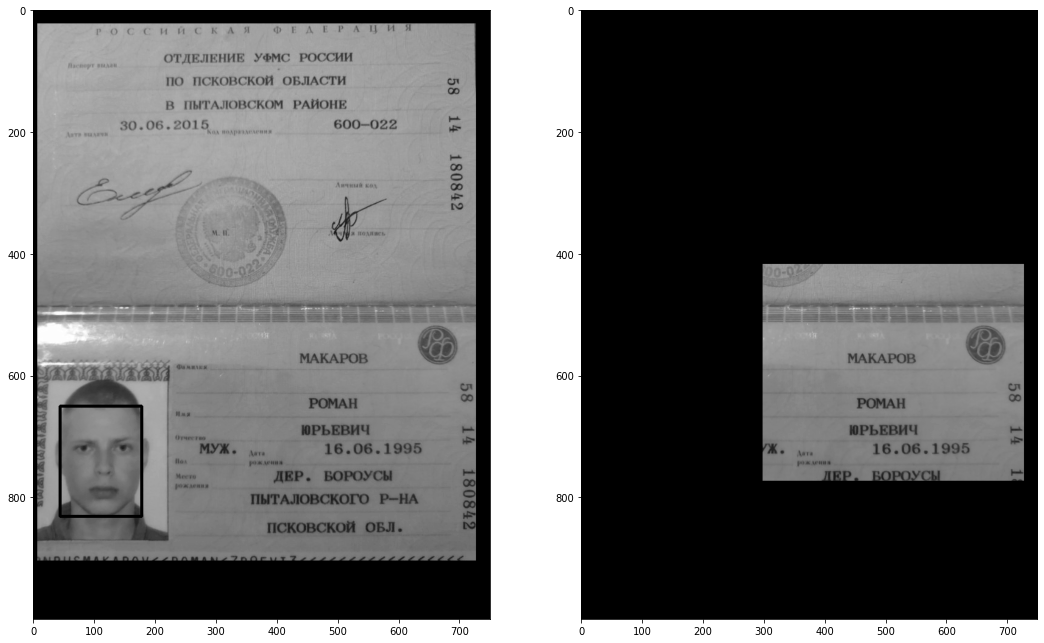

OK! answer= {'Фамилия': 'МАКАРОВ', 'Имя': 'РОМАН', 'Отчество': 'ЮРЬЕВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 36ms/step


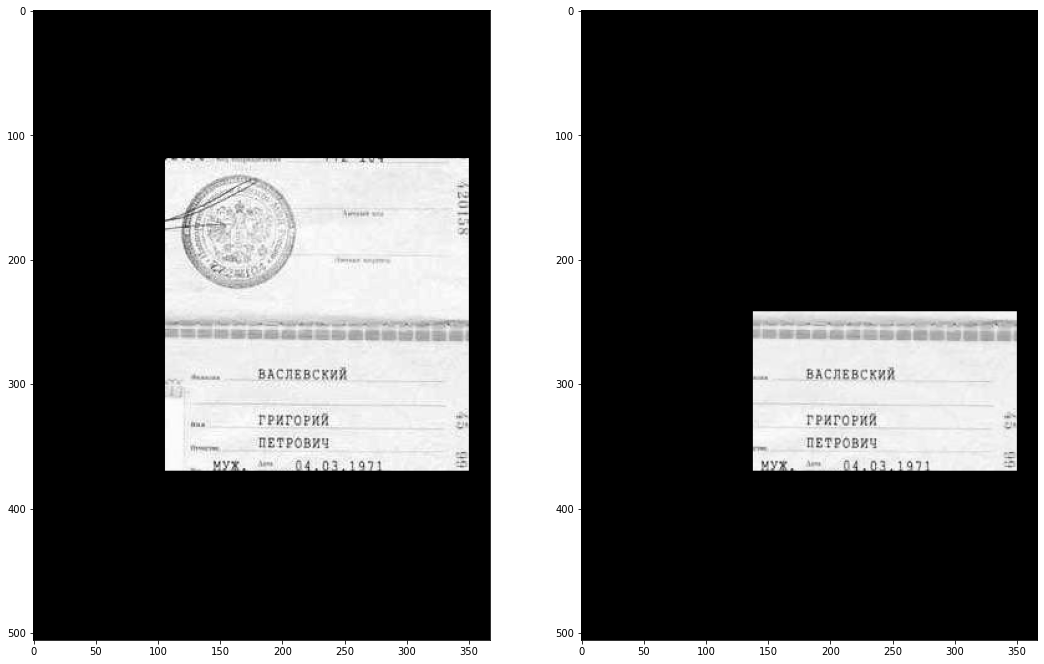

OK! answer= {'Фамилия': 'ВАСЛЕВСКИЯ', 'Имя': 'ГРКГОРЖЯ', 'Отчество': 'ПЕТРОВИЦ'}
----------------------------------------
1/1 [==============================] - 0s 27ms/step


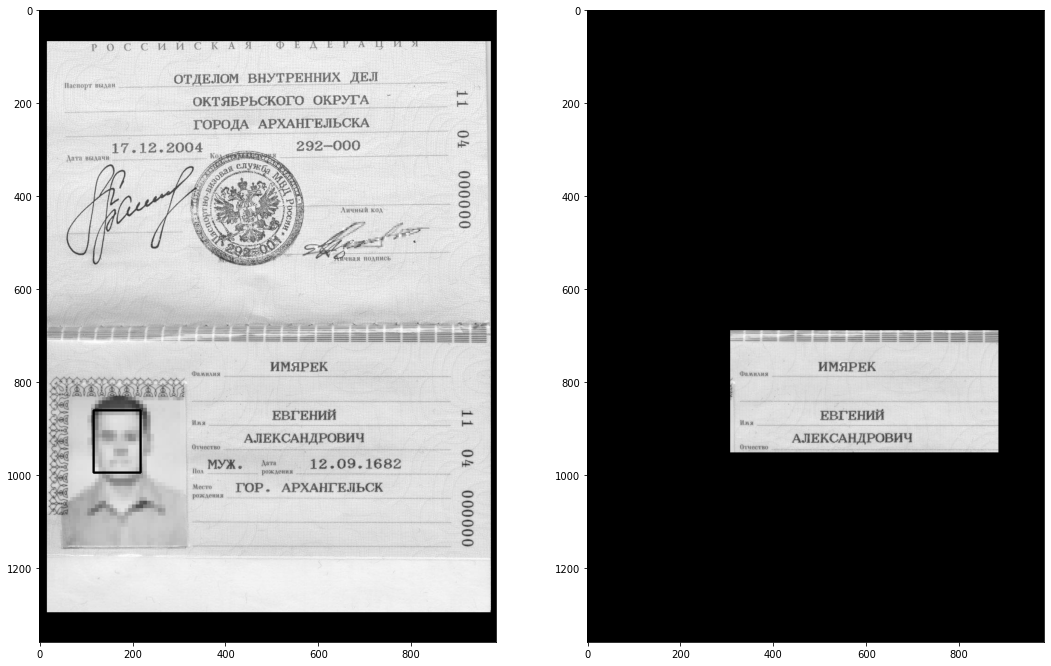

OK! answer= {'Фамилия': 'ИМЯРЕК', 'Имя': 'ЕВГЕНИЙ', 'Отчество': 'АЛЕКСАНДРОВИЧ'}
----------------------------------------
1/1 [==============================] - 0s 26ms/step


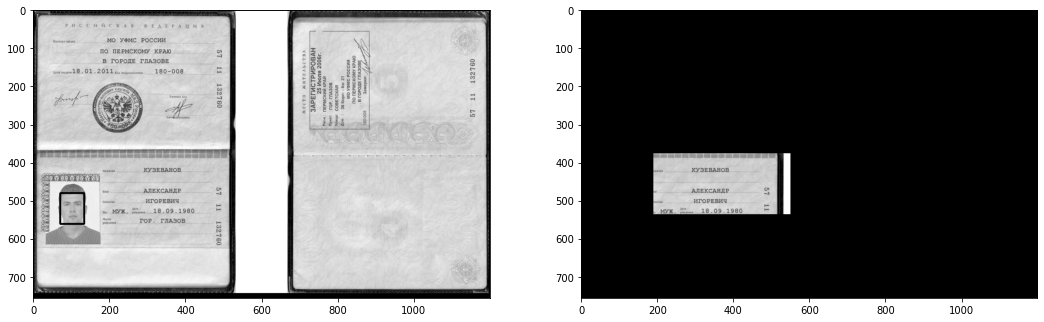

NameNotFoundError <> file_name, texts: 8.jpeg [([[289, 413], [391, 413], [391, 429], [289, 429]], 'КУЗЕВАНОВ', 0.9932002135446734), ([[285, 460], [392, 460], [392, 486], [285, 486]], 'АЛЕКСАНДР', 0.9994462508345311), ([[481, 465], [497, 465], [497, 477], [481, 477]], 'Сл', 0.9993199019150413), ([[481, 475], [497, 475], [497, 489], [481, 489]], '2', 0.4266954181015524), ([[293, 491], [387, 491], [387, 511], [293, 511]], 'ИГОРЕВИЧ', 0.9881126498468714), ([[313, 517], [427, 517], [427, 537], [313, 537]], '18.09.1980', 0.9997923508122353), ([[481, 507], [497, 507], [497, 529], [481, 529]], 'г', 0.2723345660734289)]
----------------------------------------
1/1 [==============================] - 0s 52ms/step


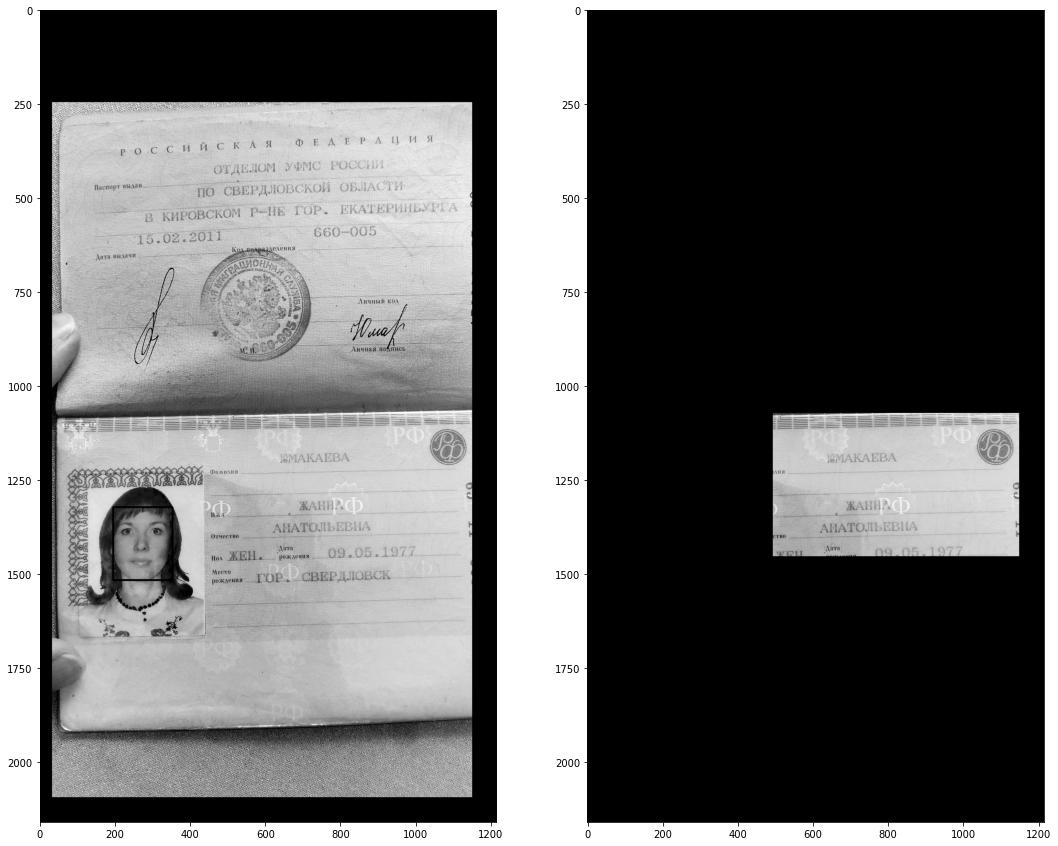

NameNotFoundError <> file_name, texts: 9.jpeg [([[930, 1106], [1028, 1106], [1028, 1160], [930, 1160]], 'РФ', 0.9978518614796553), ([[631, 1173], [827, 1173], [827, 1209], [631, 1209]], 'ЬАКАЕВА', 0.2975795367928784), ([[500, 1224], [526, 1224], [526, 1232], [500, 1232]], 'Т1', 0.1412029395335349), ([[681, 1289], [863, 1289], [863, 1343], [681, 1343]], 'ЖАННРФ', 0.9785637511483505), ([[614, 1353], [883, 1353], [883, 1398], [614, 1398]], 'АНАТОЛЬЕВНА', 0.9935807092531478), ([[501, 1395], [531, 1395], [531, 1407], [501, 1407]], 'ТНО', 0.35001105653526104), ([[633, 1423], [675, 1423], [675, 1443], [633, 1443]], 'Дата', 0.9584373831748962), ([[829, 1421], [892, 1421], [892, 1458], [829, 1458]], 'п5', 0.4398973486581252), ([[906, 1422], [1004, 1422], [1004, 1454], [906, 1454]], '1977', 0.5315384268760681)]
----------------------------------------
1/1 [==============================] - 0s 32ms/step
Not found face --> aborted
----------------------------------------


In [ ]:
for file_name in filenames:   
    try:
        texts = convert_image2gray_text(file_name, denoiser=billateral_denoiser) 
        answer = get_text_result(texts, tr_conf=0.25)  
        print("OK! answer=", answer) 
    except NotFacesFoundError:
        print("Not found face --> aborted")
    except NameNotFoundError as e:
        print("NameNotFoundError <> file_name, texts:", file_name, texts)
    print("--" * 20) 
    

In [ ]:
images = []
sizes = []
for file_name in filenames:   
    img, original_size = process_image(file_name)
    images.append(img)
    sizes.append(original_size[:2][::-1])

res = model.predict(np.asarray(images), batch_size=len(images))

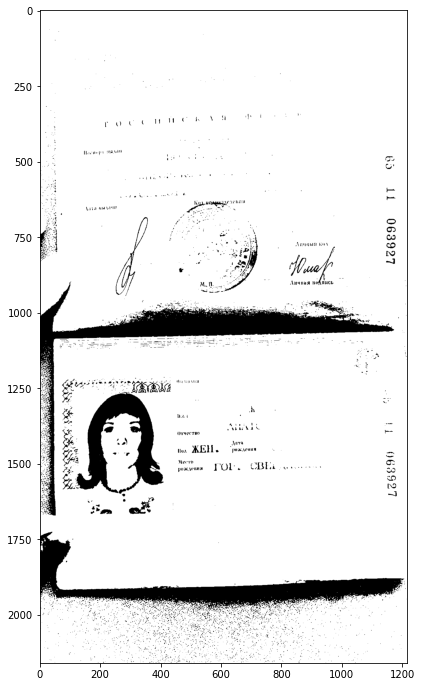

sub_pictures: [(0, 0, 1215, 2160)]
['ГОР']
['СВЕРДЛОВСК']
['Лчл', 'ЖЕН', 'Мегто', 'рождешия']
['Дчта', 'рождения']
not_text []
not_text []


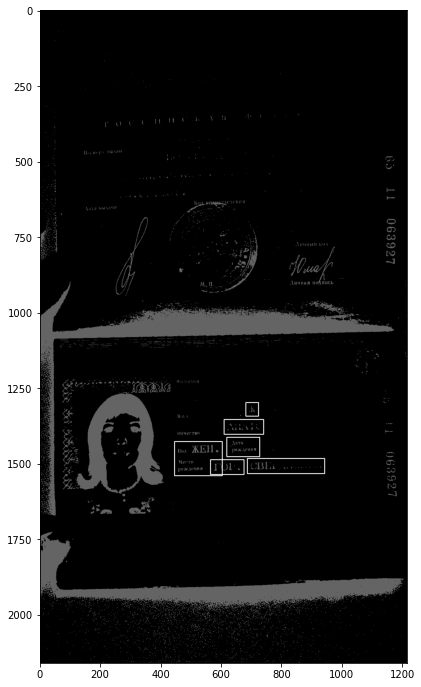

[[(564, 1487, 111, 49, 'ГОР'),
  (686, 1483, 256, 50, 'СВЕРДЛОВСК'),
  (445, 1427, 158, 113, 'Лчл ЖЕН Мегто рождешия'),
  (618, 1413, 109, 64, 'Дчта рождения')]]

In [ ]:
# # подход через разбивку на страницы , далее на каждой странице свой поиск

# В этой версии не используем
# def suppress_boxes(boxes, x_min, y_min, x_max, y_max):
#     "подавляем вложенные box, в случае, если полное поглощение"
#     boxes = [list(b) for b in boxes if (b[1] >= y_min)]  # and (b[0] + b[2] <= x_max) and (b[1] + b[3] <= y_max)
#     boxes = sorted(sorted(boxes, key=lambda b: b[0]), key=lambda b: b[1])  # по возрастанию у ( по возрастанию х)
#     res = []
#     while boxes:
#         box = boxes.pop()  # наибольшее у ( наинаибольшее х) из оставшихся
#         x, y, w, h = box
#         if not boxes:
#             res.append(box)      #    если не с кем сравнивать
#         else:
#             for nxt_box in boxes:
#                 [x2, y2, w2, h2] = nxt_box                     
#                 if (x >= x2) and (y >= y2) and (x + w <= x2 + w2) and (y + h <= y2 + h2): 
#                     break  #  текущий отброшен. т.к. среди оставшихся найден больший по отношению к текущему
#             else:    
#                 res.append(box)   #   если совпадений не встречено
#     return res


# def get_faces_coord(im_colored, x_min, y_min, x_max, y_max):              # хуже
#     "default_cnn , - возвращаем 1 box"
#     faces = face_cascade.detectMultiScale(image=img_c, scaleFactor=1.1, minNeighbors=4, minSize=(60, 60))
#     selected_faces = suppress_boxes(faces, x_min, y_min, x_max, y_max)
#     if selected_faces:
#         return selected_faces[0]
#     raise NotFacesFoundError

# def get_results(res):
#     "парсинг текста на предмет наличия абзацев"
#     keys = ("Фамилия", "Имя", "Отчество")
#     res = sorted(res, key=lambda coord: coord[1])[: 3]
#     answer = {}
#     for k in range(len(res)):
#         name = res[k][-1].upper()
#         for j in range(len(answer), len(keys)):
#             pos = keys[j]
#             name_s = name.split()
#             if not name_s: 
#                 break
#             elif pos.upper() in name_s:
#                 ind = name_s.index(pos)
#                 name = " ".join(name_s[j + 1:])
#                 if not name and k + 1 > len(answer):
#                     print("Not found", res)
                
#             answer[pos] = name_s.pop(0).title()
#             name = " ".join(name_s)

#     return answer   
    

# def get_borders(gray_img, kernel):
#     dilated = cv2.dilate(gray_img, kernel, iterations=6)  # dilate , more the iteration more the dilation
#     contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  

#     # проверка: если 2 корневых блока с уровнем "-1" (2 разворота на 1 скане) 
#     sub_pictures = [] 
#     hh, ww = gray_img.shape

#     for contour, hr in zip(contours, hierarchy[0]):
#         x, y, w, h = cv2.boundingRect(contour)
#         if (hr[-1] == -1) and ((w * 2.4 > ww) or (2.4 * h > hh)) and (w * 1.2 < h):
#             sub_pictures.append((x, y, w, h))

#     sub_pictures = sub_pictures or [(0, 0, gray_img.shape[1], gray_img.shape[0])]  # если подстраниц нет - берем целую
#     print("sub_pictures:", sub_pictures)
#     return sub_pictures


# def picture_handle(res, big_img, big_img_gray, xx, yy, ww, hh, kernel, filename):
#     img2 = big_img[yy: yy + hh + 1, xx: xx + ww + 1]
#     img_gray = big_img_gray[yy: yy + hh + 1, xx: xx + ww + 1]

#     x_min, x_max = img2.shape[1] // 4, img2.shape[1] * 17 // 20
#     y_min, y_max = img2.shape[0] // 2, img2.shape[0] * 17 // 20

#     dilated = cv2.dilate(img2, kernel, iterations=6)
#     contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

#     for contour in contours:
#         [x, y, w, h] = cv2.boundingRect(contour)
#         if not(x_min < x < x_max) or not(y_min < y < y_max) or (w < 40) or (h < 40):
#             continue

#         mask = get_mask(img_gray.shape, x, y, x + w, y + h)
#         save_rectangle(img_gray, mask, filename)
    
#         try:
#             text = reader.readtext(filename, detail=0, paragraph=False, text_threshold=0.7)
#             # print("text:", text, end="||")
#             text = [words for words in text if all(word.isalpha() for word in words.split())]
#             # print(text)
#             if text:
#                 res.append((x, y, w, h, " ".join(text)))
#                 print(text)
#             else: 
#                 print("not_text", text)
#         except Exception as e:
#             print(f"not parsed and len(text)= {len(text)}, ...", e, text)

#         cv2.rectangle(img2, (x, y), (x + w, y + h), (255, 0, 255), 2)

#     plt.figure(figsize=(12, 12))
#     plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
#     plt.show()



# def text_extr(file_name):
#     img_gray = cv2.imread(file_name, 0)  
#     img = cv2.bilateralFilter(img_gray, 5, 50, 75)  # похоже луччше Гауссовского фильтра 
#     # img = cv2.medianBlur(img_gray, 5,)
#     # img2gray  = cv2.fastNlMeansDenoising(img_gray , None, 10, 7, 21)
#     # img2gray  = cv2.medianBlur(img_gray, 5, 5)
#     # image_masked = cv2.GaussianBlur(img_gray, (7, 7), 0)
#     # image_masked = cv2.Canny(image_masked, 100, 140)

#     ret, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # в "ret" вернется порог разделения!
#     mask = cv2.threshold(img, int(ret * 0.8), 255, cv2.THRESH_BINARY)[1]  # порог разделения  принудительно понижен
#     image_masked = cv2.bitwise_and(img, img, mask=mask)
#     # image_masked = cv2.erode(image_masked, np.ones((3, 3)), iterations=1)
#     # image_masked = cv2.dilate(image_masked, np.ones((3, 3)), iterations=3)
    
#     new_img = cv2.threshold(image_masked, 20, 100, cv2.THRESH_BINARY_INV)[1] 

#     plt.figure(figsize=(12, 12))
#     plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
#     plt.show()

#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5), )  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
#     sub_pictures = get_borders(new_img, kernel)

#     # соберем результат с каждой подстранички
#     results = [[] for _ in range(len(sub_pictures))]

#     for j, [x, y, w, h] in enumerate(sub_pictures):
#         picture_handle(results[j], new_img, img, x, y, w, h, kernel, CURRENT)

#     return results


# results = text_extr(filenames[-1])
# results

In [ ]:
# # правильным считаем бОльший
# answer = sorted([get_results(res) for res in results], key=lambda x: len(x))[-1]
# answer

{'Фамилия': 'Дчта', 'Имя': 'Рождения', 'Отчество': 'Лчл'}

In [ ]:
# # get grayscale image
# def get_grayscale(image):
#     return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# # noise removal
# def remove_noise(image):
#     return cv2.medianBlur(image,5)
 
# #thresholding
# def thresholding(image):
#     return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# #dilation
# def dilate(image):
#     kernel = np.ones((5,5),np.uint8)
#     return cv2.dilate(image, kernel, iterations = 1)
    
# #erosion
# def erode(image):
#     kernel = np.ones((5,5),np.uint8)
#     return cv2.erode(image, kernel, iterations = 1)
# #opening - erosion followed by dilation
# def opening(image):
#     kernel = np.ones((5,5),np.uint8)
#     return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
# #canny edge detection
# def canny(image):
#     return cv2.Canny(image, 100, 200)
# #skew correction
# def deskew(image):
#     coords = np.column_stack(np.where(image > 0))
#     angle = cv2.minAreaRect(coords)[-1]
#     if angle < -45:
#         angle = -(90 + angle)
#     else:
#         angle = -angle
#     (h, w) = image.shape[:2]
#     center = (w // 2, h // 2)
#     M = cv2.getRotationMatrix2D(center, angle, 1.0)
#     rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#     return rotated
    
# #template matching
# def match_template(image, template):
#     return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [ ]:
# for image_file in filenames:
#     current = "current.png"
#     print(image_file)
#     img = cv2.imread(image_file, 0)
#     img = cv2.bilateralFilter(img, 5, 50, 75)
#     cv2.imwrite(current, img, )
#     text = reader.readtext(current, detail=0, paragraph=False, text_threshold=0.7)
#     print(text)
#     print("--" * 20)


0.jpeg
['( (', 'ПАСПОРТНО', 'визоВым', 'ОТДЕЛЕНИЕМ', 'овд', 'ПРЕСНЕНСКОГО', 'РАИОНА', 'УВД', 'шАо', 'ГОРОДА МОСКВЫ', '09 . 11', '201', '772-112', '5', '5', '"щм4', 'ТРАМП', 'ДОНАЛЬД', 'Джон', 'мУХ', '1 4', '0 6 . 1 946', 'ГОР', 'КУИНС', 'ПТАТ', 'НЬЮ-ИОРК', '5', 'СПА', 'а']
----------------------------------------
1.jpeg
['( € и и € к ^ Я', 'Т4', 'мО', 'УФМС', 'РоССИИ', 'ПО МУРМАНСКОЙ ОБЛАСТИ', 'ГОРОДЕ МОНЧЕГОРСК', '6', '2008', '123', '005', '7/', 'ё', 'ХАЛАБУДИНА', 'ЮЛИЯ', 'АЛЕКСЕЕВНА', '1988', 'МОНЧЕГОРСК', 'ё', '8']
----------------------------------------
2.jpeg
['С € и и € К ^ я', 'ф 1 А € ₽ А Ц и', 'ОТДЕЛОМ ВНУТРЕННИХ ДЕЛ', 'ГОР', 'КРАСНОЗНАМЕНСК', '6', '16 . 10.2016', '100-128', '8', 'ОННАя', '3', 'ШАПОШНИКОВА', 'ВИКТОРИЯ', 'НИКОЛАЕВНА', 'АЕН', '1 4', '0 9 . 1985', 'ГОР', 'КРАСНОЗНАМЕНСК', '8', "5'", '<<<Пробная', 'страничка', 'Паспорт', 'РФ', '2017>>>', '<<<Стоимость', 'программы', '10 $>>>', '<<<Еша11:', '6аске-апек@ 9ша11', 'соп>>> >', '700-', 'Саглоа']
-----------------------

In [ ]:
# kernel = np.ones((5, 5), np.uint8)
# for image_file in filenames:
#     current = "current.png"
#     print(image_file)
#     img = cv2.imread(image_file, 0)
#     img = cv2.bilateralFilter(img, 3, 50, 75)
#     cv2.imwrite(current, img)
#     text = reader.readtext(current, detail=0, paragraph=False, text_threshold=0.7)
#     print(text)
#     print("--" * 20)

4.png
['ТА"47 ПТДЕЛА УФМС Рассии', 'ПО САНКТ-ПЕТЕРБУРГ}', 'ЛЕНИНГРАЛЕКОНОЕЛ', 'могкицскам', '~НЕ ГОР САНКТ ПЕТЕРБУРТА', 'Ее', '2012', "'НП-047", 'таьи', '2', 'Тим#', '6нррмлгхы:', "'-п 6", '1- ₽', 'ши ', 'Чпп15', 'Сшла^иг', 'скилит', 'шигав1', 'АмДРн', 'АндтишиЧ', '0', '1', 'Г₽ ЕликАЕК', '1ав', 'птмикъпэктл', "'", '6₽', '9л.озак950 5 , ;490051 ; ;а!у,аЦЪ5;;;<с;<;; ;<;; ;', 'ЪП 1 5ы79 9 ; ;а ш:-апа 25ап<;.,121 Па]ттпа:.1Е']
----------------------------------------
6.jpeg
['РОВД', "'МИТИНа", 'ГОР', 'МОСЕЕН', '17.0 ]', '2000', '712-10 4', 'ВАСЛЕ ВСКИН', 'ГРКГОРИЯ', 'ПЕТРОВНЧ', 'нуз', '04.01,1971', 'С;#ДаянСкОЕ', 'КРАСНОЯРС:ОГО', 'КРяя']
----------------------------------------
0.jpeg
['С € м и € к ^', 'ПАСПОРТНО-визовым', 'ОТДЕЛЕНИЕМ', 'овд', 'ПРЕСНЕНСКОГО', 'РАЙОНА', 'УВД', 'шАо', 'ГОРОДА МОСКВЫ', '09.11.201', '772-112', '5', "'м  ", 'ТРАМП', 'ДОНАЛЬД', 'ДЖОн', 'мУж', '14 . 0 6 . 1 946', '5', 'ГОР', 'КУИНС', 'ШТАТ', 'НЬЮ-ИОРК', '5', 'США', '&']
----------------------------------------
1.

KeyboardInterrupt: ignored

In [ ]:
# kernel = np.ones((5, 5), np.uint8)
# for image_file in filenames:
#     current = "current.png"
#     print(image_file)
#     img = cv2.imread(image_file, 0)
#     ret, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     rets = [int(ret * k) for k in (0, 0.1, 0.15, 0.2, 0.3, 0.4)]
#     for ret_ in rets:
#         img = cv2.bilateralFilter(img, 3, ret_, min(int(ret_ * 1.3), 100))
#         # mask = cv2.erode(img, kernel, iterations=1)
#         # mask = cv2.dilate(mask, kernel, iterations=3)
#         # ret, _ = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # в "ret" вернется порог разделения!
#         # mask = cv2.threshold(mask, int(ret * 0.6), 255, cv2.THRESH_BINARY)[1]  # порог разделения  принудительно понижен
#         # img = cv2.bitwise_and(img, img, mask=mask)

#         cv2.imwrite(current, img)
#         text = reader.readtext(current, detail=0, paragraph=False, text_threshold=0.7)
#         print(text)
#     print("--" * 20)

4.png
['Т1 А"47 ОТДЕЛА УФМС РОССИИ', 'ПО САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛ;', 'Гтр__ы', 'могкокском', 'НЕ ГОР САНКТ ПЕТЕРБУРГА', '2012', '78П-047', 'Саэ&', '2 +', '8', 'Тадгчс', 'м~нмаша', 'хэры ау 53', '@шьзъш', 'Ч,п5,', 'Стшазъыгеру', 'сОкаЛОТ', 'шкшива', 'АНДРЕИ', 'АНДРЕЕНИЧ', 'ПеРЕ .р', 'музк -', 'пэтп', '1 997', 'ГОР СОЛИкАМСК', 'С-в3', 'пеРыскоГижкРАя', '>', '6а', 'У#. 5894 4 91 У ;;4хЕ #е <;яуоав€€', '4015 639 93 9%1 5 9 20 9289 М <<<< <<<<< <2121[2378 0! ,7 <16']
['1 ,', 'ОТДЕЛА УФМС РОССИИ', 'ПО САНКТ-ПЕТЕРБУРГУ Н ЛЕНИНГРАДСКОН ОБЛ;', 'Рт', '~ыы', '=', 'могковскОМ', '~НЕ ГОР САНКТ ПЕТЕГБУРГА', 'Хьть -523', '2012', 'я81-047', 'т1-4;', 'сн', '8', 'ТяГЧа', 'НжннЯяГЯГа', 'шу=у н', 'Елшеаша', 'Ппп 5', 'Ст шаз шыгы)', 'соВаЛОТ', 'шишв1', 'АНДРЕн', 'АНДРЕНИЧ', 'ПЕРЕ.лрат', '~ъ-К', '101', '1 997', 'ГОР СОЛИКАМЕК', 'ВлшРев', 'птгыгкогп края', "'", '6а', 'У#Ш 5 894 4 ШУ<;;нБ ₽е1 < ; яшивЫ]5< <<<<;;<<;;;<<; <', "'9 9 3 9 #. 5 9 209269 М < <<< < <<<< <2121[237д [! ,7 <1 Б", '7П Бл', '5

KeyboardInterrupt: ignored